In [1]:
#%matplotlib inline
import theano
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'raise'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
from glob import glob
import seaborn as sns
#import ipdb

def get_subj_num(filename):
    f = open(filename, 'r')
    header = f.readline()
    f.close()
    subj_num = int(header[header.find('ID:')+4:header.find('Task type')])
    return subj_num

def prep_data(filename):
    subj_num = get_subj_num(filename)
    df = pd.read_csv(filename, delimiter='\t', header=1)
    df = df[~pd.isnull(df.Trial)]
    
    df.columns = df.columns.str.strip()
    df = df.drop(df.columns[df.columns.str.find('Unna')>-1], 1) # drop extraneous columns

    # calculate RT and code by side (left: 0, right: 1)
    df['response'] = (df['Response Made by Subject'].str.find('Right') > -1).astype(int)
    df['rt'] = (df.loc[:, 'Response time'] - df.loc[:, 'Target Phase Start Time']) * 10e-4
    df = df[~pd.isnull(df.rt)] # remove trials with no response

    # get the pavlovian bias terms (need prev correct as well as nuisence regressor)
    df['prev_correct'] = np.concatenate([[0], np.array(df.Outcome == 'SUCCESS', dtype=int)[:-1]])
    df['prev_reward'] = np.concatenate([[0], np.array(df.Amount>0, dtype=int)[:-1]])

    df['subj_idx'] = [subj_num] * len(df)
    df['trial_type'] = df['Trial Category']
    df['target_duration'] = df['Target Phase Duration'] * 10e-4
    
    # Code the target direction (as well as possible, this is a guess)
    df['stim'] = ['N/A'] * len(df)
    R = (df['Response Made by Subject'].str.find('Left') == 0) & (df['Outcome']=="Failure") | \
        (df['Response Made by Subject'].str.find('Right') == 0 & (df['Outcome']=="Success")) | \
        (df['Response Made by Subject'].str.find('Right') > 0)
    L = (df['Response Made by Subject'].str.find('Right') == 0) & (df['Outcome']=="Failure") | \
        (df['Response Made by Subject'].str.find('Left') == 0 & (df['Outcome']=="Success")) | \
        (df['Response Made by Subject'].str.find('Left') > 0)
    df.loc[R, 'stim'] = 'R'
    df.loc[L, 'stim'] = 'L'
    df['subj_idx'] = [subj_num] * len(df)
#     if sum(df['rt'] > 0) == 0:
#         print df
#         raise
    df = df[df['rt'] > 0] # restrict sample to valid trials
    
    return df[
        ['stim', 'rt', 'trial_type', 'target_duration', 
         'prev_correct', 'prev_reward', 'subj_idx']
    ]

### Read files
files = glob('/home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_*.csv')
subj_list = pd.read_csv('~/projects/imagen/data/sandbox_subject_list.csv').Subject.values[0:20]
subj_list.sort()

all_data = []
for ii, f in enumerate(files):
    if get_subj_num(f) in subj_list:
      print('Reading file: ' + f)
      all_data.append(prep_data(f))

# Task conditions - associated w/ indicator variables
conditions = ('disp_side', 'tau_target', 'reward', 'high_reward', \
   'low_reward', 'prev_reward', 'prev_correct')

# Data is comprised of 3 book-keeping variables and indicators for each condition
group_data = {el:[] for el in conditions}
group_data['rt'] = []
group_data['subj_id'] = []
group_data['trial_category'] = []

t = 0
for ii, data in enumerate(all_data):
    if data.shape[0] > 0:
        group_data['subj_id']        += [t] * data.shape[0]
        #group_data['rt']             += list(1 / np.array(data['rt']))
        group_data['rt']             += list(np.array(data['rt']*1000.))
        group_data['disp_side']      += np.array(data.stim.str.find('L') == 0, dtype=int).tolist()
        group_data['tau_target']     += list(1 / np.array(data['target_duration']*1000.) - np.mean(1 / np.array(data['target_duration']*1000.)))
        group_data['reward']         += np.array(data.trial_type.str.find('NO_WIN') == 0, dtype=int).tolist()
        group_data['low_reward']     += np.array(data.trial_type.str.find('SMALL_WIN') > -1, dtype=int).tolist()
        group_data['high_reward']    += np.array(data.trial_type.str.find('BIG_WIN') > -1, dtype=int).tolist()
        group_data['prev_correct']   += data.prev_correct.tolist()
        group_data['prev_reward']    += data.prev_reward.tolist()
        group_data['trial_category'] += data.trial_type.tolist()
        t += 1

group_data = pd.DataFrame(group_data)
n_subj = len(set(group_data.subj_id))

print("Subject's Requested: %d" % len(subj_list))
print("Subject's In dataset: %d" % n_subj)

### Display cumulative distribtions of 1/RT
#fig, ax = plt.subplots(figsize=(8, 6))
#cc = sns.color_palette("Set2")
#summary = list()
#for label, color in zip('BIG_WIN SMALL_WIN NO_WIN'.split(), cc):
#    
#    x = group_data.loc[group_data.trial_category==label, 'rt']
#    x = x[~np.isnan(x)]
#    x.sort()
#    x = np.flipud(x)
#    rt = np.cumsum(np.ones(len(x)) / len(x))
#    plt.plot(x, rt, 'd', color=color, label=label)
#
#ax.set_xlim(8, 1)
#plt.legend(loc='lower right')
#ax.set_yscale('logit')
#ax.set_xlabel('RT (Hz)')
#plt.show()

Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000075578857.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000015439849.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000023358860.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000020320615.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000083236777.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000069858614.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000022084493.csv
Reading file: /home/dan/projects/imagen/data/archived/Recieved/MID/preprocessed/MID_BL_behavioraldata/mid_000009803741.csv
Reading file: /h

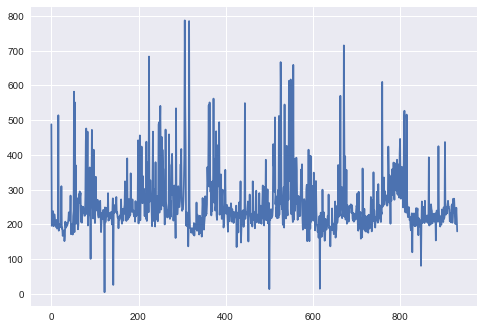

0


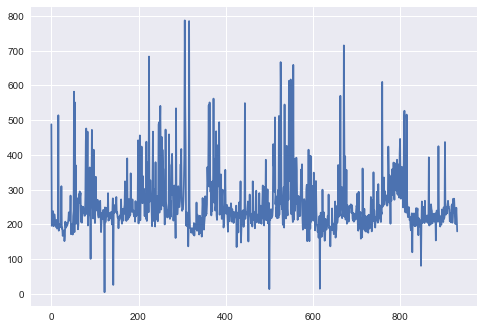

In [2]:
plt.plot(group_data['rt'].values)
plt.show()

mask = group_data['rt'] > 1000
group_data = group_data[~mask]
mask = group_data['rt'] > 1000

print(sum(mask))

plt.plot(group_data['rt'].values)
plt.show()

### Define Hierarchical Models ##
# Group model: subject ID and each condition
subj_idx     = group_data['subj_id'].values   
tau_target   = group_data.tau_target.values
disp_side    = group_data.disp_side.values
reward       = group_data.reward.values
low_reward   = group_data.low_reward.values
high_reward  = group_data.high_reward.values
prev_correct = group_data.prev_correct.values
prev_reward  = group_data.prev_reward.values

group_data_backup = group_data

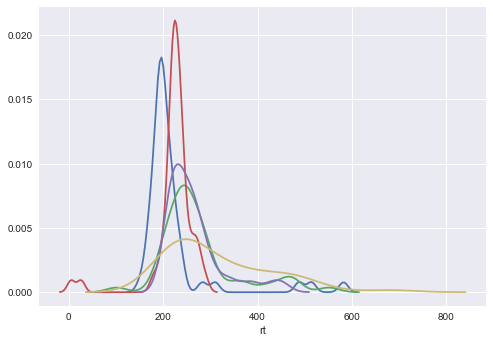

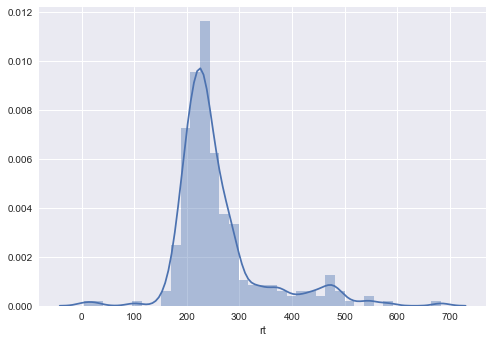

In [3]:
group_data = group_data[group_data['subj_id'] <= 4]
#group_data = group_data_backup

# Group model: subject ID and each condition
subj_idx     = group_data['subj_id'].values   
tau_target   = group_data.tau_target.values
disp_side    = group_data.disp_side.values
reward       = group_data.reward.values
low_reward   = group_data.low_reward.values
high_reward  = group_data.high_reward.values
prev_correct = group_data.prev_correct.values
prev_reward  = group_data.prev_reward.values

n_subj = len(set(group_data.subj_id))

for i in range(0,n_subj):
    sns.distplot(group_data['rt'][group_data['subj_id'] == i], hist = False)
plt.show()
    
sns.distplot(group_data['rt'])
plt.show()

#with pm.Model() as test:
#    rt = pm.ExGaussian('rt', mu = 250, sigma = 10, nu = 30)
#    trace = pm.sample(2000)

#pm.traceplot(trace, varnames=['rt'])

#sns.distplot(trace)
#plt.show()

In [4]:
conditions  = ('disp_side', 'tau_target', 'reward', 'high_reward', 'low_reward', 'prev_reward', 'prev_correct')
model_conds = list(['high_reward']) #['high_reward', 'low_reward']
print(model_conds)

['high_reward']


In [134]:
centered_model = None
offcenter_model = None
fixed_model = None

## Centered, fixed nu and sd:
with pm.Model() as fixed_model:
    group_params = dict()
    subj_params  = dict()
    
    ## ------------------- #
    ## Group Parameters
    ## ------------------- #
    group_params['mu_intercept']  = pm.Normal('mu_intercept' , mu = 250, sd = 50)
    group_params['sd_intercept']  = pm.Uniform('sd_intercept', lower = 5, upper = 100)
        
    for cond in model_conds:
        group_params['mu_beta_'+cond] = pm.Normal( 'mu_beta_' + cond, mu = 0, sd = 20)
        group_params['sd_beta_'+cond] = pm.Uniform('sd_beta_' + cond, lower = 2, upper = 40)
    
    ## ------------------- #
    ## Subject Parameters
    ## ------------------- #
    # Mean components
    subj_params['intercept'] = pm.Normal('intercept', mu = group_params['mu_intercept'], sd = group_params['sd_intercept'], shape = n_subj)    

    for cond in model_conds:
        name = 'beta_' + cond
        subj_params[name] = pm.Normal(name, mu = group_params['mu_'+name], sd = group_params['sd_'+name], shape = n_subj)
       
    ## ------------------- #    
    ## Reaction Time
    ## ------------------- #
    mu_rt = subj_params['intercept'][subj_idx]
    for cond in model_conds:
        param_name = 'beta_' + cond
        mu_rt = mu_rt + subj_params[param_name][subj_idx]*group_data[cond].values

    ## ------------------- #
    ## Likelihood
    ## ------------------- #
    rt = pm.ExGaussian('rt', mu = mu_rt, sigma = 80, nu = 50, observed = group_data.rt.values)

## Centered parameterization:
with pm.Model() as centered_model:
    group_params = dict()
    subj_params  = dict()
    
    ## ------------------- #
    ## Group Parameters
    ## ------------------- #
    group_params['mu_intercept']  = pm.Normal('mu_intercept' , mu = 250, sd = 50)
    group_params['sd_intercept']  = pm.Uniform('sd_intercept', lower = 5, upper = 100)
    
    group_params['mu_stdev']  = pm.Normal('mu_stdev' , mu = 130, sd = 30)
    group_params['sd_stdev']  = pm.Uniform('sd_stdev', lower = 5, upper = 20)

    group_params['mu_nu']  = pm.Normal('mu_nu' , mu = 50, sd = 10)
    group_params['sd_nu']  = pm.Uniform('sd_nu', lower = 5, upper = 10)
    
    for cond in model_conds:
        group_params['mu_beta_'+cond] = pm.Normal( 'mu_beta_' + cond, mu = 0, sd = 20)
        group_params['sd_beta_'+cond] = pm.Uniform('sd_beta_' + cond, lower = 2, upper = 40)
    
    ## ------------------- #
    ## Subject Parameters
    ## ------------------- #
    # Mean components
    subj_params['intercept'] = pm.Normal('intercept', mu = group_params['mu_intercept'], sd = group_params['sd_intercept'], shape = n_subj)    

    for cond in model_conds:
        name = 'beta_' + cond
        subj_params[name] = pm.Normal(name, mu = group_params['mu_'+name], sd = group_params['sd_'+name], shape = n_subj)
    
    # Ex-Gaussian SD and Tau
    stdev = pm.Normal('stdev', mu = group_params['mu_stdev'], sd = group_params['sd_stdev'], shape = n_subj)    
    nu  = pm.Normal('nu', mu = group_params['mu_nu'], sd = group_params['sd_nu'], shape = n_subj)

    stdev_all = stdev[subj_idx]
    nu_all    = nu[subj_idx]
    
    ## ------------------- #    
    ## Reaction Time
    ## ------------------- #
    mu_rt = subj_params['intercept'][subj_idx]
    for cond in model_conds:
        param_name = 'beta_' + cond
        mu_rt = mu_rt + subj_params[param_name][subj_idx]*group_data[cond].values

    ## ------------------- #
    ## Likelihood
    ## ------------------- #
    rt = pm.ExGaussian('rt', mu = mu_rt, sigma = 80, nu = 50, observed = group_data.rt.values)

with pm.Model() as offcenter_model:
    group_params = dict()
    subj_params  = dict()
    
    ## ------------------- #
    ## Group Parameters
    ## ------------------- #
    group_params['mu_intercept']  = pm.Normal('mu_intercept' , mu = 250, sd = 50)
    group_params['sd_intercept']  = pm.Uniform('sd_intercept', lower = 5, upper = 100)
    
    group_params['mu_stdev']  = pm.Normal('mu_stdev' , mu = 130, sd = 30)
    group_params['sd_stdev']  = pm.Uniform('sd_stdev', lower = 5, upper = 20)

    group_params['mu_nu']  = pm.Normal('mu_nu' , mu = 50, sd = 10)
    group_params['sd_nu']  = pm.Uniform('sd_nu', lower = 5, upper = 10)
    
    for cond in model_conds:
        group_params['mu_beta_'+cond] = pm.Normal( 'mu_beta_' + cond, mu = 0, sd = 20)
        group_params['sd_beta_'+cond] = pm.Uniform('sd_beta_' + cond, lower = 2, upper = 40)
    
    ## ------------------- #
    ## Subject Parameters
    ## ------------------- #
    subj_params['int_offset'] = pm.Normal('int_offset', mu=0, sd=1, shape=n_subj)
    subj_params['intercept']  = pm.Deterministic('intercept', group_params['mu_intercept'] + subj_params['int_offset'] * group_params['sd_intercept'])
    
    for cond in model_conds:
        name = 'beta_' + cond   
        subj_params[name+'_offset'] = pm.Normal(name+'_offset', mu=0, sd=1, shape=n_subj)
        subj_params[name]  = pm.Deterministic(name, group_params['mu_'+name] + subj_params[name+'_offset'] * group_params['sd_'+name])
    
    # Off-center parameterizations:
    stdev_offset = pm.Normal('stdev_offset', mu=0, sd=1, shape=n_subj)
    stdev        = pm.Deterministic('stdev', group_params['mu_stdev'] + stdev_offset * group_params['sd_stdev'])
        
    nu_offset = pm.Normal('nu_offset', mu=0, sd=1, shape=n_subj)
    nu        = pm.Deterministic('nu', group_params['mu_nu'] + nu_offset * group_params['sd_nu'])    
    
    stdev_all = stdev[subj_idx]
    nu_all    = nu[subj_idx]
    
    ## ------------------- #
    ## Reaction Time
    ## ------------------- #
    mu_rt = subj_params['intercept'][subj_idx]
    for cond in model_conds:
        param_name = 'beta_' + cond
        mu_rt = mu_rt + subj_params[param_name][subj_idx]*group_data[cond].values

    ## ------------------- #
    ## Likelihood
    ## ------------------- #
    rt = pm.ExGaussian('rt', mu = mu_rt, sigma = stdev_all, nu = nu_all, observed = group_data.rt.values)
    
def print_model_and_likelihoods(model, name):
    print('------------------------------')
    print(name + ' model:')
    for RV in model.test_point.keys():
        print(RV, model.test_point[RV])

    print('\nLikelihoods:')
    for RV in model.basic_RVs:
        print(RV.name, 'logp: ', RV.logp(model.test_point))


In [219]:

with pm.Model() as offcenter_tf_model:
    group_params = dict()
    subj_params  = dict()
    
    ## ------------------- #
    ## Group Parameters
    ## ------------------- #
    group_params['mu_intercept']  = pm.Normal('mu_intercept' , mu = 250, sd = 50)
    group_params['sd_intercept']  = pm.Uniform('sd_intercept', lower = 5, upper = 100)
    
    group_params['mu_stdev']  = pm.Normal('mu_stdev' , mu = 130, sd = 30)
    group_params['sd_stdev']  = pm.Uniform('sd_stdev', lower = 5, upper = 20)

    group_params['mu_nu']  = pm.Normal('mu_nu' , mu = 50, sd = 10)
    group_params['sd_nu']  = pm.Uniform('sd_nu', lower = 5, upper = 10)
    
    for cond in model_conds:
        group_params['mu_beta_'+cond] = pm.Normal( 'mu_beta_' + cond, mu = 0, sd = 20)
        group_params['sd_beta_'+cond] = pm.Uniform('sd_beta_' + cond, lower = 2, upper = 40)
    
    ## ------------------- #
    ## Subject Parameters
    ## ------------------- #
    subj_params['int_offset'] = pm.Normal('int_offset', mu=0, sd=1, shape=n_subj)
    subj_params['intercept']  = pm.Deterministic('intercept', group_params['mu_intercept'] + subj_params['int_offset'] * group_params['sd_intercept'])
    
    for cond in model_conds:
        name = 'beta_' + cond   
        subj_params[name+'_offset'] = pm.Normal(name+'_offset', mu=0, sd=1, shape=n_subj)
        subj_params[name]  = pm.Deterministic(name, group_params['mu_'+name] + subj_params[name+'_offset'] * group_params['sd_'+name])
    
    # Off-center parameterizations:
    stdev_offset = pm.Normal('stdev_offset', mu=0, sd=1, shape=n_subj)
    stdev        = pm.Deterministic('stdev', group_params['mu_stdev'] + stdev_offset * group_params['sd_stdev'])
        
    nu_offset = pm.Normal('nu_offset', mu=0, sd=1, shape=n_subj)
    nu        = pm.Deterministic('nu', group_params['mu_nu'] + nu_offset * group_params['sd_nu'])    
    
    stdev_all = stdev[subj_idx]
    nu_all    = nu[subj_idx]
    
    #tf = pm.Binomial('tf', n = 1, p = 0.05, shape = n_subj)
    #tf_all = tf[subj_idx]
    
    ## ------------------- #
    ## Reaction Time
    ## ------------------- #
    mu_rt = subj_params['intercept'][subj_idx]
    for cond in model_conds:
        param_name = 'beta_' + cond
        mu_rt = mu_rt + subj_params[param_name][subj_idx]*group_data[cond].values

    mu_rt = pm.Deterministic('mu_rt', subj_params['intercept'][subj_idx] + subj_params[param_name][subj_idx]*group_data[cond].values)
        
    ## ------------------- #
    ## Likelihood
    ## ------------------- #
    #egrt = pm.ExGaussian('egrt', mu = mu_rt, sigma = stdev_all, nu = nu_all, shape = len(subj_idx))
    #urt  = pm.Uniform.dist(lower = 0, upper = 900, shape = len(subj_idx))

    #w  = pm.Uniform('w', lower=0, upper=0.1)
    rtlist = []
    urt    = pm.Uniform.dist(lower = 0, upper = 900)
    for response_num in range(len(subj_idx)):
        egrt = pm.ExGaussian.dist(mu = subj_params['intercept'][subj_idx[response_num]], sigma = 0, nu = 0)
        rtlist.append( pm.Mixture('rt' + str(response_num), w=[0.95, 0.05], comp_dists=[egrt,urt], observed=group_data.rt.values[response_num]) )

    rt = theano.tensor.stack(rtlist)

In [220]:
# Centered model and likelihoods:
#print_model_and_likelihoods(fixed_model    , 'Fixed')
#print_model_and_likelihoods(centered_model , 'Centered')
print_model_and_likelihoods(offcenter_tf_model, 'Off-center')

------------------------------
Off-center model:
mu_intercept 250.0
sd_intercept_interval__ 0.0
mu_stdev 130.0
sd_stdev_interval__ 0.0
mu_nu 50.0
sd_nu_interval__ 0.0
mu_beta_high_reward 0.0
sd_beta_high_reward_interval__ 0.0
int_offset [ 0.  0.  0.  0.  0.]
beta_high_reward_offset [ 0.  0.  0.  0.  0.]
stdev_offset [ 0.  0.  0.  0.  0.]
nu_offset [ 0.  0.  0.  0.  0.]

Likelihoods:
mu_intercept logp:  -4.830961538632819
sd_intercept_interval__ logp:  -1.3862943758893767
mu_stdev logp:  -4.320135914866828
sd_stdev_interval__ logp:  -1.3862943112150206
mu_nu logp:  -3.2215236261987186
sd_nu_interval__ logp:  -1.386294331049108
mu_beta_high_reward logp:  -3.9146708067586635
sd_beta_high_reward_interval__ logp:  -1.3862944040555047
int_offset logp:  -4.594692666023363
beta_high_reward_offset logp:  -4.594692666023363
stdev_offset logp:  -4.594692666023363
nu_offset logp:  -4.594692666023363
rt0 logp:  -9.798127036878302
rt1 logp:  -9.798127036878302
rt2 logp:  -9.798127036878302
rt3 logp:

In [221]:
niter = 1000
njobs = 1

### Model fitting ###
def fit_model(model):
    with model:
        means, sds, elbos = pm.variational.advi(n = 1000)
        #start = pm.find_MAP()
        step  = pm.NUTS(scaling = means, target_accept = 0.95, max_treedepth = 15)
        trace = pm.sample(niter, start = means, step = step, njobs = njobs, tune = 500)
        
    return trace

#trace_f = fit_model(fixed_model)
#trace_c = fit_model(centered_model)
trace_o = fit_model(offcenter_tf_model)

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead


KeyboardInterrupt: 

In [213]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace, varname, var2name):
    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size/len(trace)
    print('Percentage of Divergent %.5f' % divperc)

    pm.traceplot(trace, varnames=[varname])
    pm.traceplot(trace, varnames=[var2name])

    var  = trace[varname]
    var2 = trace[var2name]
    
    if len(var2.shape) > 1:
        var2 = var2[:,0]

    if len(var.shape) > 1:
        var = var[:,0]
    
    # plot the estimate for the mean of log(τ) cumulating mean
    #mvar = [np.mean(var[:i]) for i in np.arange(1, len(var))]
    #plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    #plt.plot(mvar, lw=2.5)
    #plt.ylim(0, 2)
    #plt.xlabel('Iteration')
    #plt.ylabel('MCMC mean of ' + varname)
    #plt.title('MCMC estimation of ' + varname)
    #plt.show()

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space

    plt.figure(figsize=(10, 6))
    plt.scatter(var2[divergent == 0], var[divergent == 0], color='r')
    plt.scatter(var2[divergent == 1], var[divergent == 1], color='g')
    #plt.axis([-20, 50, -6, 4])
    plt.ylabel(varname)
    plt.xlabel(var2name)
    plt.title('scatter plot between '+ varname + ' and ' + var2name)
    plt.show()

Number of Divergent 208
Percentage of Divergent 0.20800


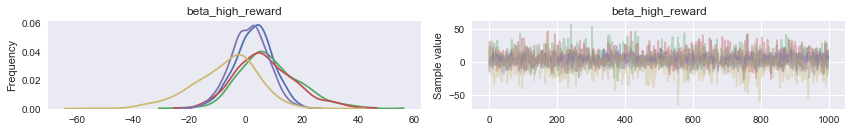

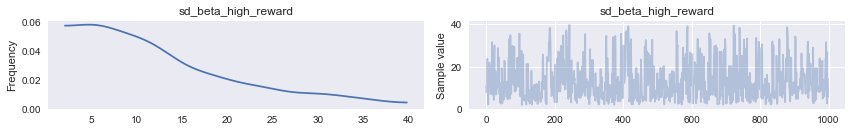

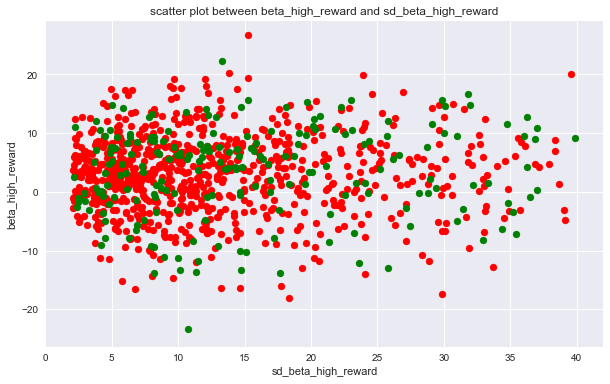

In [214]:
#trace_1.
#report_trace(trace_1, 'mu_beta_high_reward', 'sd_beta_high_reward')
#report_trace(trace_1, 'mu_intercept', 'sd_intercept')
#report_trace(trace_1, 'sd_beta_high_reward', 'sd_intercept')
report_trace(trace_o, 'beta_high_reward', 'sd_beta_high_reward')

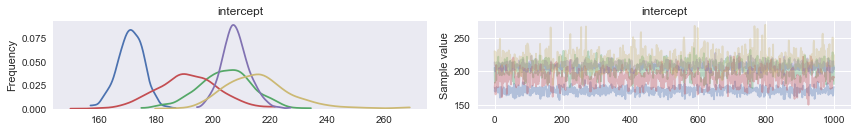

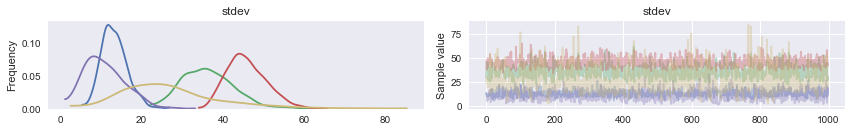

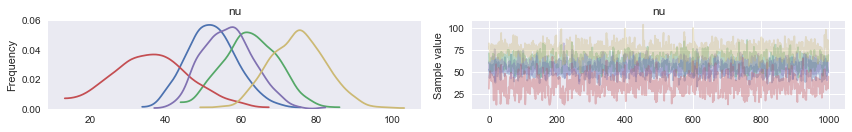

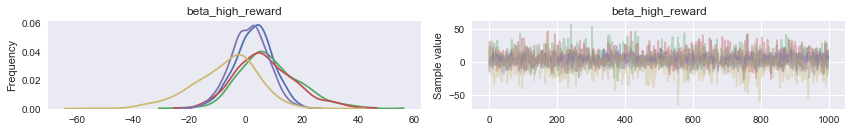

In [215]:
pm.traceplot(trace_o, varnames=['intercept'])
pm.traceplot(trace_o, varnames=['stdev'])
pm.traceplot(trace_o, varnames=['nu'])
plt.show()

for cond in model_conds:
    name = 'beta_' + cond

    pm.traceplot(trace_o, varnames=[name])
    plt.show()

    #pm.autocorrplot(trace_1, varnames=[name])
    #plt.subplots_adjust(top=0.75)
    #plt.suptitle('Chain Auto-Correlations')
    #plt.show()

#pm.effective_n(trace_1)
#pm.gelman_rubin(trace_1)

#plt.plot(pm.geweke(trace_1['mu_intercept'])[:,1], 'o')
#plt.axhline(1, c='red')
#plt.axhline(-1, c='red')
#plt.title('Geweke')
#plt.gca().margins(0.05)

In [216]:
ppc = pm.sample_ppc(trace_o, model=offcenter_model, samples = 5000)
np.asarray(ppc['rt']).shape

100%|██████████| 5000/5000 [00:02<00:00, 1678.57it/s]


(5000, 263)

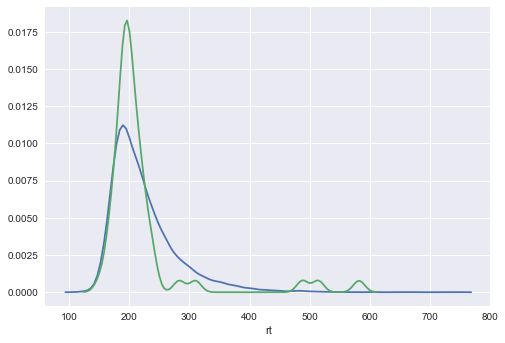

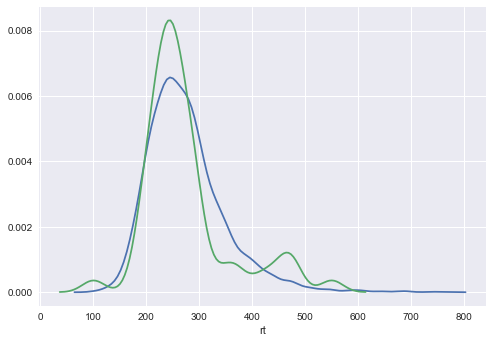

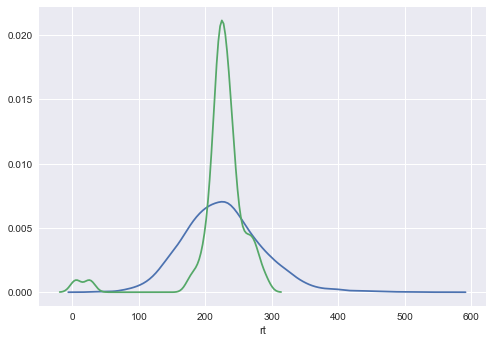

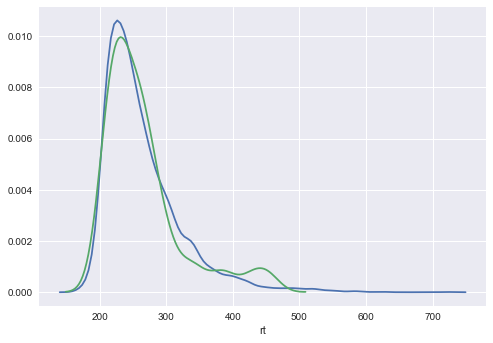

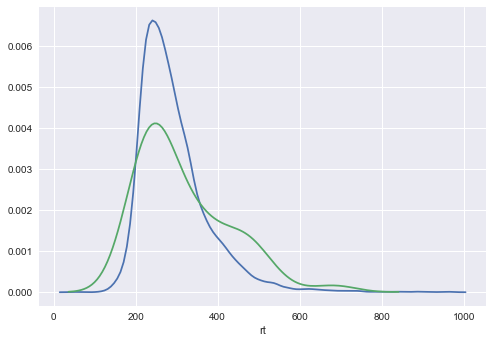

(5000, 263)


In [217]:
subj_cols = 0
for j in range(0,5):
    subj_cols = subj_cols + len(subj_idx[subj_idx == j])
    sns.distplot(ppc['rt'][:,subj_cols-1], hist = False)
    sns.distplot(group_data['rt'][group_data['subj_id'] == j], hist = False)
    plt.show()
    
#sns.distplot(ppc)
plt.show()

print(ppc['rt'].shape)
#ax.axvline(group_data.rt.values)
#ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

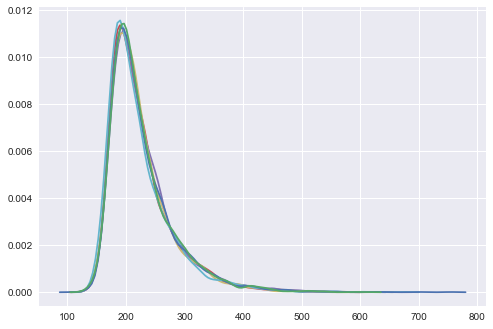

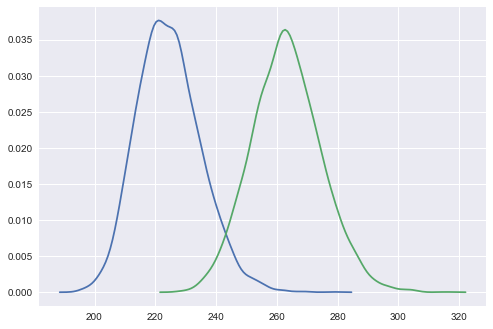

In [65]:
ppc['rt'][:,subj_idx == 0].shape
for i in range(0,2):
    sns.distplot(ppc['rt'][:,i], hist = False)

ppc['rt'][:,subj_idx == 1].shape
for i in range(49,53):
    sns.distplot(ppc['rt'][:,i], hist = False)
    
plt.show()


ppc['rt'][:,subj_idx == 0].shape
sns.distplot(np.mean(ppc['rt'][:,0:48],1), hist = False)    

ppc['rt'][:,subj_idx == 1].shape
sns.distplot(np.mean(ppc['rt'][:,49:112],1), hist = False)
plt.show()

In [ ]:
subj_idx == 1

In [ ]:
np.mean(ppc['rt'][:,0:2],1)

In [ ]:
trace_1

In [ ]:
### Get expectation and variance of each subject parameter of interest

# Get the Expecations for all of the variables and match it to the subjects
t = 0
id_key = {}
for ii, d in enumerate(all_data):
    if d.shape[0] > 0:
        id_key[t] = data.subj_idx.values[0]
        t += 1


vars_of_interest = ['beta_target_dur', 'beta_left_side', 
                    'beta_reward', ## Low reward is misnamed -- it's really just reward
                    'beta_high_reward',
                    'eps',
                    'intercept']

new_parameter_names = {
    'beta_target_dur': 'Target Duration Coeff',
    'beta_left_side': 'Target is Left Coeff',
    'beta_reward': 'Cue is Rewarded Coeff',
    'beta_high_reward': 'Cue is High Reward Coeff',
    'eps': 'StDev of 1/RT',
    'intercept': 'Intercept'
}

summary_stats = []
for subj in set(subj_idx):
    for var in vars_of_interest:
        sample = trace_1.get_values(var)[:, subj]
        sample = sample.reshape(2500, 3)[:500].reshape(1500) # remove burned samples
        summary_stats.append({
                'Subject': id_key[subj],
                'Parameter': new_parameter_names[var],
                'Expectation': np.mean(sample),
                'Variance': np.var(sample)
            })
summary_stats = pd.DataFrame(summary_stats)
# summary_stats.to_csv('MIDT_SubjectFits_All.csv')


# any subect with a particularly wide reaction time distribution may be indicitive that the
# model doesn't capture their data well. Here we collapse all of the very high sigma
# values for the 1/RT distibution as 10 or greater

x = summary_stats.loc[summary_stats['Parameter']=='StDev of 1/RT','Expectation'].values
hist, bin_edges = np.histogram(x, np.arange(0, 10, 0.25))
ax = plt.bar(bin_edges[:-1], hist, width=0.2)
plt.bar(10, np.sum(x>10), color='r', width=0.2)
plt.xlim(0, 10.3)

In [45]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=data)

    trace = pm.sample()
    
with model:
    post_pred = pm.sample_ppc(trace, samples=500, size=len(data))
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 500/500 [00:00<00:00, 887.30it/s]


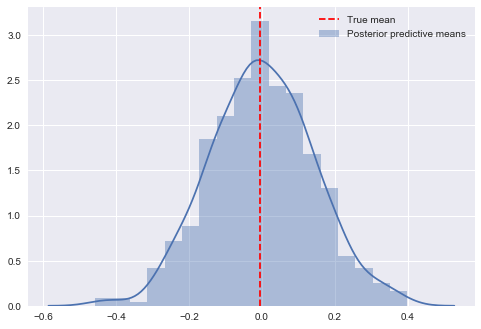

In [47]:

plt.figure()
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(data.mean(), color='r', ls='--', label='True mean')
ax.legend()

plt.show()

In [50]:
post_pred['mu']

KeyError: 'mu'